# Gas2Vec
Author: Michal Stary

Adaptation of Spec2Vec for GC-MS data. 

## Settings

In [1]:
data_path = "/storage/brno1-cerit/projects/msml/data/MoNA-export-GC-MS_Spectra.msp" #"data/MoNA-export-GC-MS_Spectra.msp"

## Spectral data
We use the Spec2Vec and MatchMS libraries to load and preprocess spectral data.

Uncomment the pip install lines or run them directly in terminal

In [1]:
import os

# this libraries may be necessary to install via pip in terminal 

#%pip install matchms 
#%pip install spec2vec 
#%pip install gensim==3.8
#%pip install tensorboard

from matchms.filtering import add_losses
from matchms.filtering import add_parent_mass
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

import tensorflow as tf
from tensorboard.plugins import projector

In [2]:
def spectrum_processing(s, min_rel_int=None):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = default_filters(s)
    #s = add_parent_mass(s)
    #s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5, n_max=500)
    s = select_by_mz(s, mz_from=0, mz_to=1000);
    #s = add_losses(s, loss_mz_from=10.0, loss_mz_to=200.0)
    s = normalize_intensities(s)

    
    s = require_minimum_number_of_peaks(s, n_required=10)
    
    if min_rel_int is not None:
        s= select_by_relative_intensity(s, intensity_from=min_rel_int)

    return s

### Spectral data at integer precision

In [3]:
%%capture
#first we train peak embeddings at integer m/z precision

# Load data from MSP file and apply filters

spectrums = [spectrum_processing(s) for s in load_from_msp(data_path)];

# Omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]


# Create spectrum documents

reference_documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums];


<AxesSubplot:>

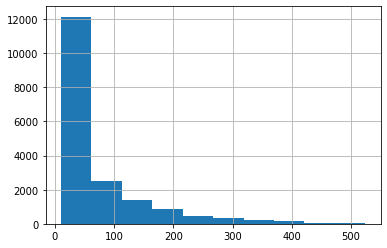

In [4]:
pd.Series(np.array(list((map(lambda r: len(r.words), reference_documents))))).hist()

In [5]:
pd.Series(np.array(list((map(lambda r: len(r.words), reference_documents))))).describe()

count    18171.000000
mean        72.357218
std         78.058832
min         10.000000
25%         25.000000
50%         40.000000
75%         86.000000
max        524.000000
dtype: float64

### Spectral data at 2dec precision


In [6]:
reference_documents_2dec = [SpectrumDocument(s, n_decimals=2) for s in spectrums];


<AxesSubplot:>

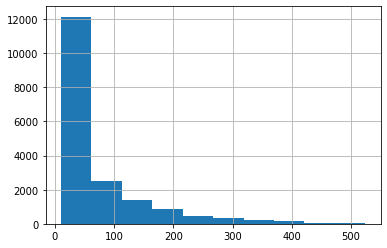

In [7]:
pd.Series(np.array(list((map(lambda r: len(r.words), reference_documents_2dec))))).hist()

## Gas2Vec model
Load or train the w2v Gensim model using spec2vec library.

Either load pretrained file or uncomment the training and train your own.

In [46]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_file = "gas2vec/references_integer.model"
model_int = train_new_word2vec_model(reference_documents, iterations=list(range(0,100,5)), filename=model_file,
                                workers=32, progress_logger=True)


The value of workers is set from 4 (default) to 32
  Epoch 1 of 95.Change in loss after epoch 1: 59837.1015625
  Epoch 2 of 95.Change in loss after epoch 2: 89362.0234375
  Epoch 3 of 95.Change in loss after epoch 3: 62946.234375
  Epoch 4 of 95.Change in loss after epoch 4: 95017.765625
  Epoch 5 of 95.Change in loss after epoch 5: 67322.4375
Saving model with name: gas2vec/references_integer_iter_5.model
  Epoch 6 of 95.Change in loss after epoch 6: 77554.0625
  Epoch 7 of 95.Change in loss after epoch 7: 98700.4375
  Epoch 8 of 95.Change in loss after epoch 8: 63756.125
  Epoch 9 of 95.Change in loss after epoch 9: 75636.625
  Epoch 10 of 95.Change in loss after epoch 10: 63903.3125
Saving model with name: gas2vec/references_integer_iter_10.model
  Epoch 11 of 95.Change in loss after epoch 11: 58802.25
  Epoch 12 of 95.Change in loss after epoch 12: 82595.875
  Epoch 13 of 95.Change in loss after epoch 13: 54227.0
  Epoch 14 of 95.Change in loss after epoch 14: 56627.1875
  Epoch 15

In [28]:
from spec2vec.model_building import train_new_word2vec_model

# train 2dec w2v 
model_file = "gas2vec/references_2dec.model"
model_2dec = train_new_word2vec_model(reference_documents_2dec, iterations=list(range(0,100,5)), filename=model_file,
                                workers=32, progress_logger=True, learning_rate_initial=0.10,)
 

The value of learning_rate_initial is set from 0.025 (default) to 0.1
The value of workers is set from 4 (default) to 32
  Epoch 1 of 95.Change in loss after epoch 1: 45896.7578125
  Epoch 2 of 95.Change in loss after epoch 2: 8516.40234375
  Epoch 3 of 95.Change in loss after epoch 3: 910.96484375
  Epoch 4 of 95.Change in loss after epoch 4: 772.78125
  Epoch 5 of 95.Change in loss after epoch 5: 2066.828125
Saving model with name: gas2vec/references_2dec_iter_5.model
  Epoch 6 of 95.Change in loss after epoch 6: 390.28515625
  Epoch 7 of 95.Change in loss after epoch 7: 4362.87109375
  Epoch 8 of 95.Change in loss after epoch 8: 386.93359375
  Epoch 9 of 95.Change in loss after epoch 9: 324.71484375
  Epoch 10 of 95.Change in loss after epoch 10: 698.4765625
Saving model with name: gas2vec/references_2dec_iter_10.model
  Epoch 11 of 95.Change in loss after epoch 11: 659.39453125
  Epoch 12 of 95.Change in loss after epoch 12: 460.765625
  Epoch 13 of 95.Change in loss after epoch 13

### Gas2Vec training observation
The loss recorded shall decrease each iteration. In our case it is crazily jumping around. Currently we have no quantitative metrics to evaluate peak/spectral embeddings quality. Therefore the choice of the best model is done rather ad-hoc by choosing the one with the lowest number. (no idea whether it is good or not)  

PS - Spec2Vec training for a reference: 

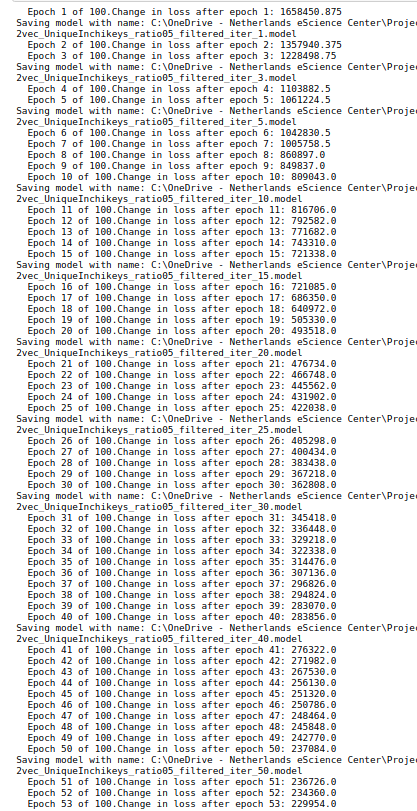

## Load and inspect the models

In [9]:
from gensim.models import Word2Vec 

# load the models
w2v = Word2Vec.load("gas2vec/references_integer_iter_55.model")    
w2v_2dec = Word2Vec.load("gas2vec/references_2dec_iter_85.model")   

In [10]:
reference_documents[0].metadata["name"]

'1-NITROPYRENE'

In [11]:
np.array(reference_documents[0].words)

array(['peak@51', 'peak@55', 'peak@57', 'peak@58', 'peak@59', 'peak@60',
       'peak@61', 'peak@62', 'peak@63', 'peak@66', 'peak@68', 'peak@70',
       'peak@72', 'peak@73', 'peak@74', 'peak@75', 'peak@76', 'peak@78',
       'peak@80', 'peak@81', 'peak@82', 'peak@83', 'peak@86', 'peak@87',
       'peak@92', 'peak@93', 'peak@94', 'peak@98', 'peak@99', 'peak@100',
       'peak@104', 'peak@107', 'peak@108', 'peak@110', 'peak@112',
       'peak@113', 'peak@115', 'peak@116', 'peak@120', 'peak@122',
       'peak@123', 'peak@124', 'peak@125', 'peak@126', 'peak@134',
       'peak@135', 'peak@137', 'peak@147', 'peak@149', 'peak@150',
       'peak@151', 'peak@159', 'peak@162', 'peak@163', 'peak@173',
       'peak@174', 'peak@175', 'peak@177', 'peak@187', 'peak@188',
       'peak@189', 'peak@190', 'peak@191', 'peak@198', 'peak@199',
       'peak@200', 'peak@201', 'peak@202', 'peak@203', 'peak@207',
       'peak@214', 'peak@217', 'peak@218', 'peak@247', 'peak@248'],
      dtype='<U8')

In [12]:
np.array(reference_documents_2dec[0].words)

array(['peak@51.00', 'peak@55.00', 'peak@57.00', 'peak@58.00',
       'peak@59.00', 'peak@60.00', 'peak@61.00', 'peak@62.00',
       'peak@63.00', 'peak@66.00', 'peak@68.00', 'peak@70.00',
       'peak@72.00', 'peak@73.00', 'peak@74.00', 'peak@75.00',
       'peak@76.00', 'peak@78.00', 'peak@80.00', 'peak@81.00',
       'peak@82.00', 'peak@83.00', 'peak@86.00', 'peak@87.00',
       'peak@92.00', 'peak@93.00', 'peak@94.00', 'peak@98.00',
       'peak@99.00', 'peak@100.00', 'peak@104.00', 'peak@107.00',
       'peak@108.00', 'peak@110.00', 'peak@112.00', 'peak@113.00',
       'peak@115.00', 'peak@116.00', 'peak@120.00', 'peak@122.00',
       'peak@123.00', 'peak@124.00', 'peak@125.00', 'peak@126.00',
       'peak@134.00', 'peak@135.00', 'peak@137.00', 'peak@147.00',
       'peak@149.00', 'peak@150.00', 'peak@151.00', 'peak@159.00',
       'peak@162.00', 'peak@163.00', 'peak@173.00', 'peak@174.00',
       'peak@175.00', 'peak@177.00', 'peak@187.00', 'peak@188.00',
       'peak@189.00', 'p

int_count : 1213188 ~ 92.3 percent of peaks
1dec_count: 62403 ~ 4.7 percent of peaks
2dec_count: 39212 ~ 3.0 percent of peaks


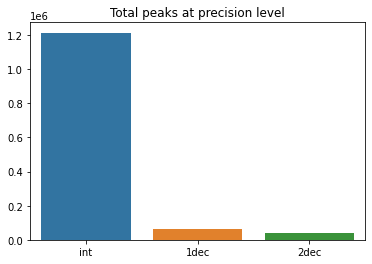

In [13]:
from collections import Counter

# get n_dec info (counts) of peaks

nested = [doc.words for doc in reference_documents_2dec ]
counter = Counter([item for sublist in nested for item in sublist])

int_count = 0
dec1_count = 0
dec2_count = 0

for name in counter: 
    suffix = name.split(".")[1]
    if suffix == "00":
        int_count += counter[name]
    elif suffix[1] == "0":
        dec1_count += counter[name]
    else:
        dec2_count += counter[name]
total = int_count + dec1_count + dec2_count
        
sns.barplot(x=["int", "1dec", "2dec"], y=[int_count, dec1_count, dec2_count])
plt.title("Total peaks at precision level")
print(f"int_count : {int_count} ~ {int_count/total*100:.1f} percent of peaks")
print(f"1dec_count: {dec1_count} ~ {dec1_count/total*100:.1f} percent of peaks")
print(f"2dec_count: {dec2_count} ~ {dec2_count/total*100:.1f} percent of peaks")

int_count : 17190 ~ 94.6 percent of spectras
1dec_count: 532 ~ 2.9 percent of spectras
2dec_count: 449 ~ 2.5 percent of spectras


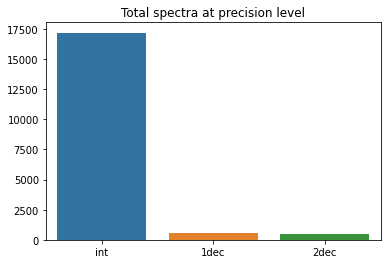

In [116]:
# get n_dec info (counts) of spectras

int_count = 0
dec1_count = 0
dec2_count = 0

for words in nested:
    doc_prec= "int"
    for name in words:
        suffix = name.split(".")[1]
        if suffix == "00":
            pass
        elif suffix[1]  == "0" and doc_prec != "2dec":
            doc_prec = "1dec"
        else:
            doc_prec = "2dec"
    if doc_prec == "int":
        int_count += 1
    elif doc_prec == "1dec":
        dec1_count += 1
    else:
        dec2_count += 1

total = int_count + dec1_count + dec2_count
        
sns.barplot(x=["int", "1dec", "2dec"], y=[int_count, dec1_count, dec2_count])
plt.title("Total spectra at precision level")
print(f"int_count : {int_count} ~ {int_count/total*100:.1f} percent of spectras")
print(f"1dec_count: {dec1_count} ~ {dec1_count/total*100:.1f} percent of spectras")
print(f"2dec_count: {dec2_count} ~ {dec2_count/total*100:.1f} percent of spectras")

### Loaded model observation
Note that even in MONA the percent of peaks on higher than integer precision is extremely low (less than 5%). Therefore there seem to be no point in training the model on higher than integer precision.  

## Evaluating the quality of peaks and spectral embeddings
Now we need to evaluate the peaks/spectral embeddings obtained by Spec2Vec.

Considering our usecases, we need to evaluate both peak (word) embeddings and spectral embeddings. 

### Peak embeddings evaluation

Possible aproaches:
* Create LM on top of our peak embeddings, observe

    -> See GC_mz_spectral_model.ipynb

### Spectral embeddings evaluation

Possible aproaches: 
* Qualitaive:
    * Create spectral embeddings and cluster it -> observe

        -> See below

    * Create a spectral embedding and inspect it via tensorboard

        -> See below or online
* Quantitative:
    * TODO - Design a similarity task (TANIMOTO )
    * TODO - Design an analogy task 

## Create a spectral embedding 

In [59]:
from spec2vec import Spec2Vec
# Define similarity_function
spec2vec_similarity = Spec2Vec(model=w2v, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

spectral_embeddings = np.empty(shape=(len(reference_documents), 300))

for i, doc in enumerate(reference_documents):
    spectral_embeddings[i] = spec2vec_similarity._calculate_embedding(doc)
    
spectral_embeddings[:10]

array([[-11.2521921 ,  66.92814401,  63.03613326, ...,  -6.68343374,
        154.10666904,  45.98240031],
       [ 83.45619161,  10.05940665,   3.9605179 , ..., -18.7849128 ,
         30.4395823 ,  59.103414  ],
       [ 23.21466286, -18.74373438,  11.96270582, ...,  19.06691796,
        -29.28918407,  -1.60732649],
       ...,
       [ 17.14168013, -17.08560857,  17.84208137, ...,  23.50678032,
        -24.0843337 ,  -3.41370882],
       [ 45.54508623, -22.87093729,  22.65664517, ...,  22.82420153,
        -20.16175343,  32.45071412],
       [ 28.17583382, -35.81548421,  33.0399032 , ...,  35.87810207,
        -26.77738867,  -4.64142304]])

In [97]:
from spec2vec import Spec2Vec
# Define similarity_function
spec2vec_similarity_2dec = Spec2Vec(model=w2v_2dec, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

spectral_embeddings_2dec = np.empty(shape=(len(reference_documents_2dec), 300))

for i, doc in enumerate(reference_documents_2dec):
    spectral_embeddings_2dec[i] = spec2vec_similarity_2dec._calculate_embedding(doc)
    
spectral_embeddings_2dec[:10]

array([[-5.11369954e+02,  3.80698083e+02, -3.99072341e+01, ...,
        -3.45036982e-01, -4.87179337e+01, -5.22550186e+02],
       [-4.76504762e+02,  3.94130255e+02, -5.20459078e+01, ...,
        -9.55190157e+01, -4.73430891e+01, -5.33751073e+02],
       [-1.63842384e+02,  7.17660288e+01, -3.44125791e+01, ...,
        -3.16705891e+01, -5.57922634e+01, -2.62216342e+02],
       ...,
       [-1.21832874e+02,  5.11804019e+01, -3.97702702e+01, ...,
        -3.03602615e+01, -6.91758343e+01, -2.22546084e+02],
       [-3.98525085e+02,  2.22960593e+02, -1.07767785e+01, ...,
         2.51991516e+01, -3.24939545e+01, -5.61225417e+02],
       [-4.07652498e+02,  2.03784955e+02, -7.69582498e+01, ...,
        -4.13878618e+00, -4.18762865e+01, -6.09671932e+02]])

In [99]:
spectral_embeddings.shape

(18171, 300)

## Cluster spectral embeddings

Now we try to cluster spectral embeddings using DBSCAN algorithm (due to automatic n_clusters formation)

We visualize the result using PCA and TSNE (eventually tsne visualisation skipped - computing takes too long) 

Note that the vectors were first normalized between 0-1 and euclidean distance was then used. As the crucial eps hyperparameter 0.8 was choosed after few trials, but the results are far from good. 

DBSCAN


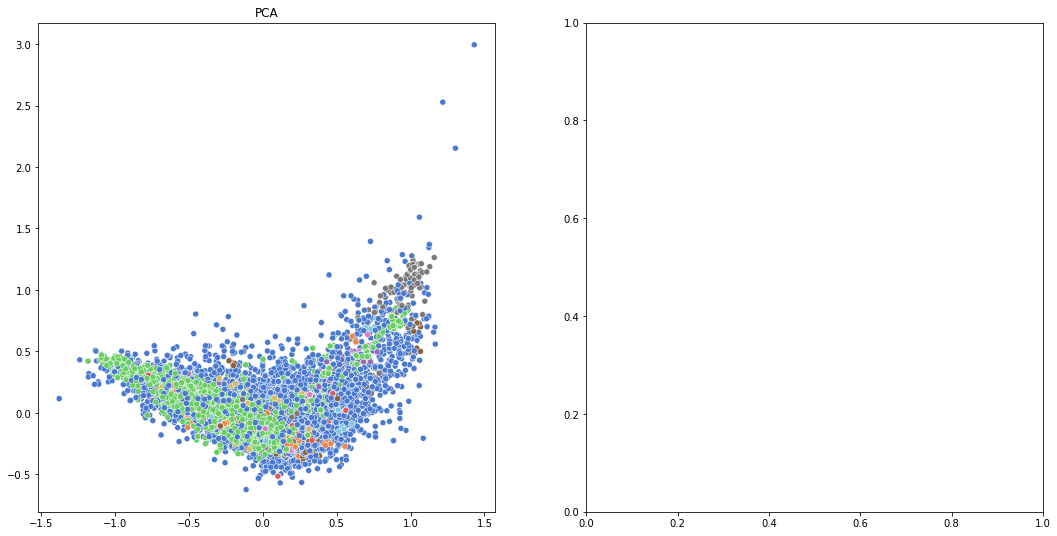

DBSCAN


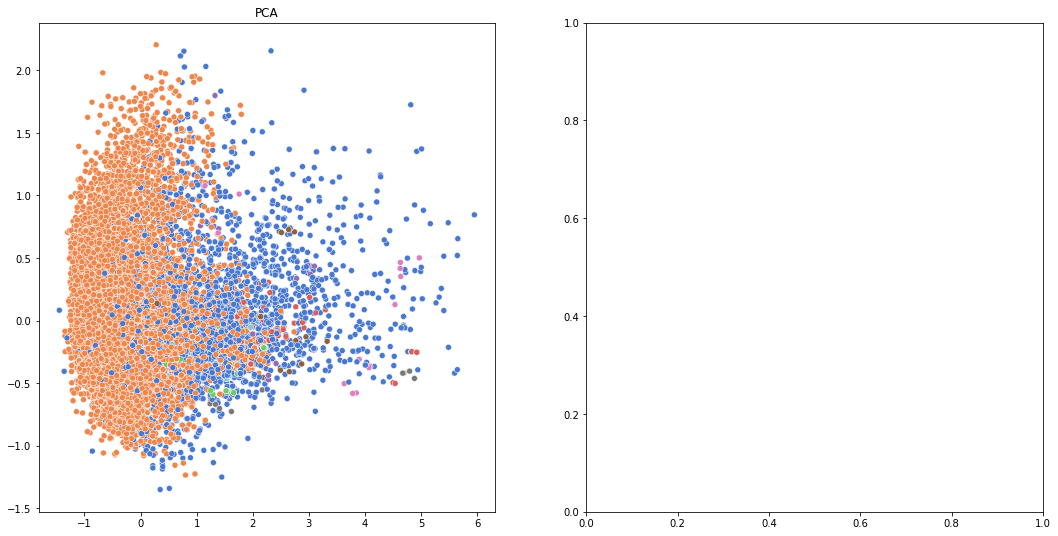

In [102]:
# (PCA, TSNE )+ (KMEANS, DBSCAN)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_pipeline = make_pipeline(MinMaxScaler(),PCA(n_components=2))
tsne_pipeline = make_pipeline(MinMaxScaler(),TSNE(n_components=2, n_jobs=-1, metric="cosine"))
 

def tsne(features):
    X_reduced = tsne_pipeline.fit_transform(features)
    return X_reduced

def pca(features):
    X_reduced = pca_pipeline.fit_transform(features)
    return X_reduced

def reduce(features, hue = None):
    res_pca = pca(features)
    #res_tsne = tsne(features)
    
    fig, ax = plt.subplots(1,2, figsize=(18,9))
    plot2D(ax[0], res_pca, "PCA", hue)
    #plot2D(ax[1], res_tsne, "TSNE", hue)
    plt.show()


def plot2D(ax, X_transformed, title, hue):
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    g = sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1],
                         hue=hue, palette="muted", ax=ax)
    g.legend_.remove()
    
    ax.title.set_text(title)

k_pipeline = make_pipeline( MinMaxScaler(),KMeans( n_clusters=8, n_jobs=-1))
d_pipeline = make_pipeline(MinMaxScaler(),DBSCAN(eps=0.8, min_samples=5, metric="euclidean", n_jobs=-1))


def kmeans(features, show=False):
    labels = k_pipeline.fit_predict(features)
    if show:
        print("KMEANS")
        print()
        reduce(features, labels)
    return labels

def dbscan(features, show=False):
    labels = d_pipeline.fit_predict(features)
    if show:
        print("DBSCAN")
        reduce(features, labels)
    return labels

labels = dbscan(spectral_embeddings, show=True)
labels_2dec = dbscan(spectral_embeddings_2dec, show=True)

In [103]:
pd.Series(labels).value_counts()

-1      9193
 1      6819
 64      163
 156     115
 8        62
        ... 
 91        5
 107       5
 155       5
 171       5
 183       5
Length: 205, dtype: int64

In [104]:
pd.Series(labels_2dec).value_counts()

 0     14032
-1      3783
 22       45
 25       16
 28       14
 21       10
 1        10
 19       10
 42       10
 31        9
 44        9
 11        8
 6         8
 9         8
 10        8
 20        8
 30        8
 12        7
 3         7
 39        7
 18        6
 33        6
 24        6
 29        6
 23        6
 7         6
 4         6
 14        6
 26        6
 32        6
 35        6
 36        6
 27        6
 34        5
 2         5
 17        5
 47        5
 5         5
 37        5
 38        5
 40        5
 43        5
 45        5
 46        5
 15        5
 8         5
 41        4
 16        4
 13        3
dtype: int64

### Clustering observation
Formed clusters are no good at PCA projection. To evaluate them properly we woudl either need to get domain expert (chemist) to go through them manually or to design an anotated dataset or to get spectral similarity dataset. 

## TODO - Clustering evaluation 

In [106]:
# evaluate clusters

## Save embeddings+clusters in tsv format (to use tf online projector)

We will save the current embeddings to make them available online via link in the online tensorborad embedding projector. 

Link to integer precision embeddings:

https://projector.tensorflow.org/?config=https%3A%2F%2Fgist.githubusercontent.com%2Fmichal-stary%2Fae0484c6e159888471b6d7d31b31516a%2Fraw%2Fd2468d14597b11fed972572c9ec40aa3f3d1673d%2Fgistfile1.txt

In [65]:
# save spectral embeddings to tsv file
np.savetxt('gas2vec/embeddings_int_top.tsv', spectral_embeddings, delimiter='\t', fmt='%.6f')

In [66]:
# save spectral embeddings to tsv file
np.savetxt('gas2vec/embeddings_2dec_top.tsv', spectral_embeddings_2dec, delimiter='\t', fmt='%.6f')

In [67]:
# save metadata with clusters
with open(os.path.join("gas2vec", 'metadata_int_top.tsv'), "w") as f:
    f.write(f"name\tcluster\n")
    for i, doc in enumerate(reference_documents):
        f.write(f"{doc.metadata['name']}\t{labels[i]}\n")


In [68]:
# save metadata with clusters
with open(os.path.join("gas2vec", 'metadata_2dec_top.tsv'), "w") as f:
    f.write(f"name\tcluster\n")
    for i, doc in enumerate(reference_documents_2dec):
        f.write(f"{doc.metadata['name']}\t{labels_2dec[i]}\n")


## Inspect embeddings + clusters via tensorboard

For a more dynamic approach, we can use the embedding projector directly in here.

In [69]:
def setup_projector(name, docs, embeddings, labels):
    # Set up a logs directory, so Tensorboard knows where to look for files
    log_dir=f'gas2vec/tf/logs/{name}'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Save Labels separately on a line-by-line manner.
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
        f.write(f"name\tcluster\n")
        for i, doc in enumerate(docs):
            f.write(f"{doc.metadata['name']}\t{labels[i]}\n")

    # Save the weights we want to analyse as a variable. Note that the first
    # value represents any unknown word, which is not in the metadata, so
    # we will remove that value.
    weights = tf.Variable(embeddings)
    # Create a checkpoint from embedding, the filename and key are
    # name of the tensor.
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

    # Set up config
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(log_dir, config)

In [70]:
setup_projector("spect_em", reference_documents, spectral_embeddings, labels)
setup_projector("spect_em_2dec", reference_documents_2dec, spectral_embeddings_2dec, labels_2dec)


In [5]:
%load_ext tensorboard
host = "zia3.cerit-sc.cz" #"localhost"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
%tensorboard --logdir gas2vec/tf/logs/spect_em --host=$host --port=8385
#!python -m tensorboard.main --logdir gas2vec/tf/logs/spect_em --port=6006

In [7]:
%tensorboard --logdir gas2vec/tf/logs/spect_em_2dec --host=$host --port=8370


In [74]:
import pkg_resources

for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)

tensorboard 2.5.0
tensorboard-plugin-wit 1.8.0


In [75]:
os.path.abspath(os.getcwd())


'/auto/brno6/home/xstary1/GC_mz_spectral_model-generate'